# Bayes en Python (MCMC)

###  Cadena de Markov Monte Carlo (MCMC), es una clase de algoritmos utilizados para muestrear distribuciones posteriores de manera eficiente.

### Usaremos las paqueterias de Python 

#### emcee : el MCMC Hammer


### Mejor ajuste lineal: En nuestro modelo los parametros serán la pendiente, la intersección, la dispersión alrededor de la linea. La dispersión será tratado como un parametro molesto.  


## Datos

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [48]:

np.random.seed()
theta_true = (20, 0.5)
xdata = 100 * np.random.random(100)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 15) #numpy.random.normal(loc=0.0, scale=1.0, size=None)
ydata = np.random.normal(ydata, 15)


### Donde $y_{data}=\theta_{0}+\theta_{1}x_{data}$

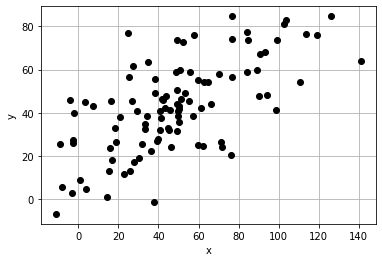

In [49]:
plt.grid()
plt.plot(xdata, ydata,'ok')
plt.xlabel('x')
plt.ylabel('y');

Asumiremos que desconocemos los errores. Ajustemos estos datos. 

## Concretemos el modelo

 Recordemos por Bayes que $P(\theta|D)\propto P(D|\theta)P(\theta)$
 donde $D$ representa los datos observados y $\theta$ el modelo. Asumiremos por tanto que nuestro modelo es lienal.    
$\hat{y}(x_{i}|\alpha, \beta)=\alpha+\beta x_{i}$. 
el likelihood esta dado por 
### $P(x_{i},y_{i}|\alpha,\beta,\sigma)\propto (2\pi\sigma^{2})^{-N/2}exp\left[\frac{-1}{2\sigma^{2}}\sum_{i-1}^{N}[y_{i}-y(x_{i}|\alpha,\beta)]^{2}\right]$

### Prior en $\alpha$, $\beta$, $\sigma$ 

### $P(\alpha,\beta)\propto(1+\beta)^{-3/2}$

Esto equivale a decir que $\alpha$ es uniformemente distribuida y $\beta$ es uniforme en $\sin{(\tan^{-1}(\beta))}$. 

### $P(\sigma)\propto 1 /\sigma$ (jeffreys Prior)
### $P(\alpha, \beta, \sigma)\propto (1/\sigma)(1+\beta^{2})^{-3/2}$

In [68]:
# Create some convenience routines for plotting

def compute_sigma_level(trace1, trace2, nbins=20):
    """desde un conjunto de trazas, bin por numero de desviaciones estandar"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtener los índices para ordenar y desordenar la matriz aplanada
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Graficar trazas y contornos"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.1)
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Trazar el modelo lineal y los contornos 2sigma"""
    ax.plot(xdata, ydata, 'ok')

    alpha, beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = alpha[:, None] + beta[:, None] * xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Trace la traza y el modelo juntos"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)

In [69]:
import emcee
print(emcee.__version__)

3.0.2


In [70]:

def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    alpha, beta, sigma = theta
    y_model = alpha + beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

In [98]:
# Here we'll set up the computation. emcee combines multiple "walkers",
# each of which is its own MCMC chain. The number of trace results will
# be nwalkers * nsteps

ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 500  # "burn-in" period to let chains stabilize
nsteps = 1000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

In [99]:
# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

CPU times: user 2.44 s, sys: 3.78 ms, total: 2.44 s
Wall time: 2.8 s
done


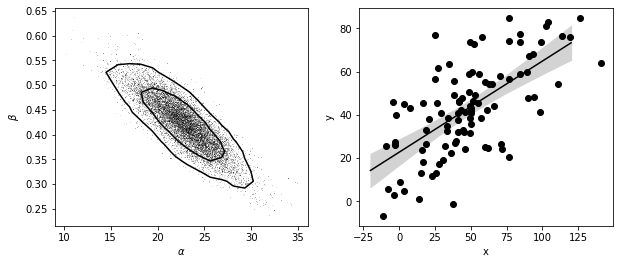

In [100]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plot_MCMC_results(xdata, ydata, emcee_trace)

### La grafica de la izquierda muestra las trazas marginalizadas sobre el parametro molesto $\sigma$. 
### La de la derecha muestra la linea que mejor ajusta con la region de incertidumbre de $2\sigma$. 
